In [1]:
%matplotlib inline

# machine learing and image processing
import cv2
from sklearn.utils import shuffle
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import ConvexHull
from matplotlib.path import Path

# import data manipulation pacakges
import pandas as pd
import numpy as np

# viewing preferecnes
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#from PIL import Image, ImageDraw
from pylab import rcParams

# miscenallous packages
from collections import Counter
import itertools
import os

In [2]:
# read in and sort all files
files = sorted([x[:-4] for x in os.listdir('faces/pngs/')])

# select an example 
f = [x for x in files if 'Aoi-Akira' in x][0]

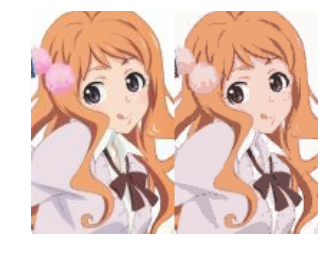

((-0.5, 199.5, 155.5, -0.5), None)

In [3]:
def reduceImage(x, NUM_COL):
    # create a working copy of image
    X = np.float64(x.copy().reshape(-1, 3))

    # train model to extract NUM_COL amount of dominant colours
    km = KMeans(n_clusters=NUM_COL, random_state=0)
    kmeans = km.fit(shuffle(X, random_state=0))
    colours = kmeans.cluster_centers_
    
    # return a reduced image only use the NUM_COL amount of colours
    predicted = np.array([colours[x] for x in kmeans.predict(X)])
    return colours, np.uint8(predicted.reshape(x.shape))


# read in and reduce image
img = {'orig': cv2.imread('faces/pngs/'+f+'.png').astype(np.uint8)}
colours, img['reduced'] = reduceImage(img['orig'], 12)

# visualize output
rcParams['figure.figsize'] = 8, 4
stacked = np.uint8(np.hstack([img['orig'], img['reduced']]))
plt.imshow(cv2.cvtColor(stacked, cv2.COLOR_BGR2RGB))
plt.axis('off'), plt.show()

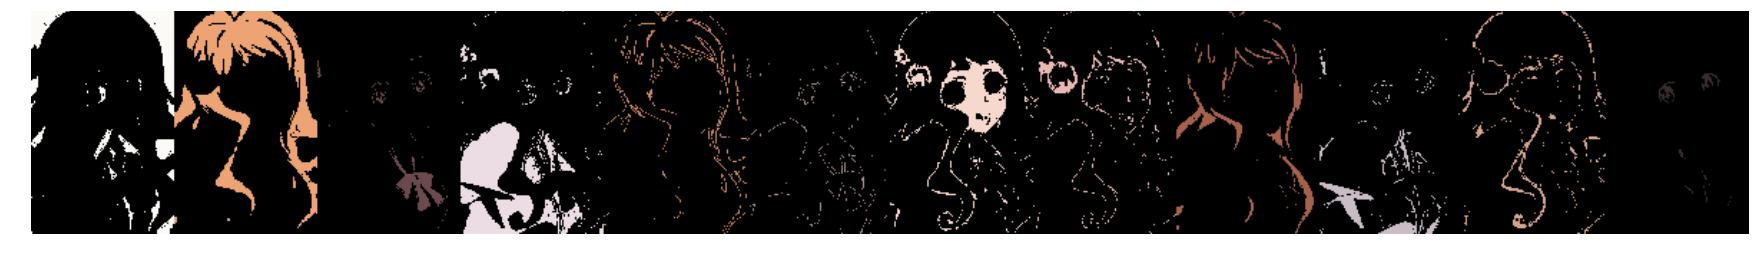

((-0.5, 1199.5, 155.5, -0.5), None)

In [4]:
def splitImage(x, colours):
    """Modified from pyimagesearch.com/2014/08/04/opencv-python-color-detection."""
    boundaries = ((x-1, x+1) for x in colours)

    # loop over the boundaries
    for (lower, upper) in boundaries:
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        # find the colors within the specified boundaries and apply mask
        mask = cv2.inRange(x, lower, upper)
        output = cv2.bitwise_and(x, x, mask=mask)
        yield output

# show the images
rcParams['figure.figsize'] = 40, 4

#show segmentations
stacked = np.hstack(splitImage(img['reduced'], colours))
plt.imshow(cv2.cvtColor(stacked, cv2.COLOR_BGR2RGB))
plt.axis('off'), plt.show()

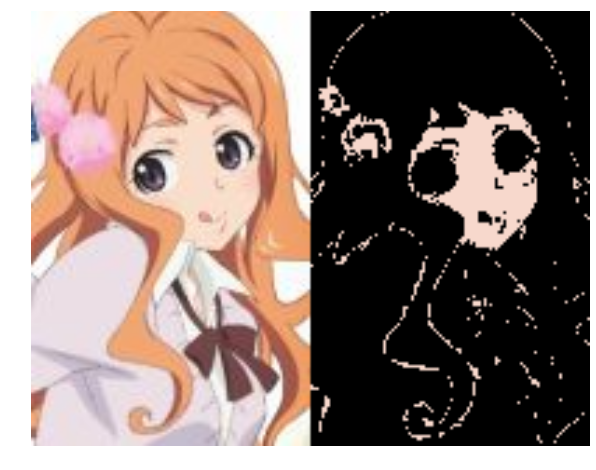

((-0.5, 199.5, 155.5, -0.5), None)

In [5]:
def removeSkin(img, f):
    """It puts the lotion in the basket or it gets the NaNs again."""
    # read in preaquired info
    fileName = 'faces/jsons/' + f + '.json'
    h, w, x, y = pd.read_json(fileName).squeeze()

    # using info obtain facial region
    M = np.zeros_like(img['orig'], dtype=np.uint32)
    M[y+h//4:y+3*h//4, x+w//4:x+3*w//4, :] = 1
    f = M*img['reduced']
    f = f[f.nonzero()].reshape(-1, 3)

    # extract skin from the dominant colour segmentation
    skinColour = np.array(Counter(map(tuple, f)).most_common(1)[0][:1])
    skin = next(splitImage(img['reduced'], skinColour))

    return skin

rcParams['figure.figsize'] = 10, 10
img['skin'] = removeSkin(img, f)
plt.imshow(cv2.cvtColor(np.hstack([img['orig'], img['skin']]), cv2.COLOR_BGR2RGB))
plt.axis('off'), plt.show()

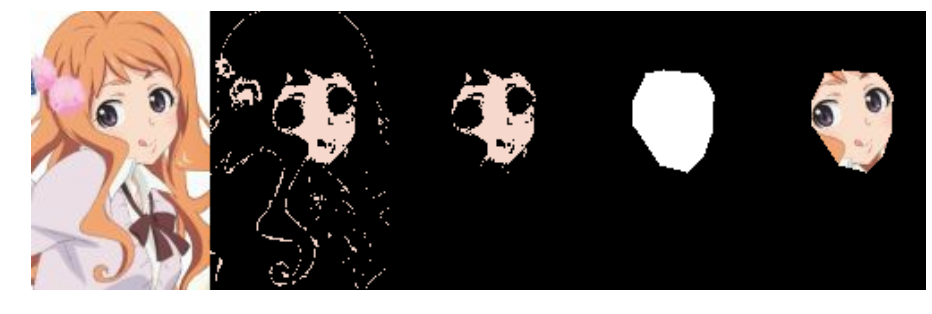

((-0.5, 499.5, 155.5, -0.5), None)

In [6]:
def scanForFace(F, X, eps=5, min_samps=1/3, SKIN_DEMONSTRATION=False):
    """DBSCANS skin and compares to OpenCV facial region to detect facial skin."""
    # performa  DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samps*(eps**3)).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    
    # package indices and labels together
    labels = db.labels_[db.labels_ != -1].reshape(-1, 1)
    indices = X[db.labels_ != -1]
    LI = np.hstack([indices, labels])

    # group positions by labels
    clusters = (LI[np.where(LI[:, 3] == x)][:, :3] for x in set(LI[:, 3]))

    # create a set of indices which exist in the CNN Facial region
    F_set = set([tuple(x) for x in F])

    # check if a DBSCAN cluster intersects with the facial region
    facial_regions = (x for x in clusters if any(set(tuple(y) for y in x) & F_set))

    # for understanding show skin detection if requested, otherwise stack and return
    if (SKIN_DEMONSTRATION):
        return X[np.where(db.labels_ != -1)]
    else:
        return np.vstack(facial_regions)


def extractFace(img, f, hull):
    """Sets up variables to pass to scanForFace() which contains the gory details."""
    # read in preaquired info
    fileName = 'faces/jsons/' + f + '.json'
    h, w, x, y = pd.read_json(fileName).squeeze()

    # get facial regions
    M = np.zeros_like(img)
    M[y+h//4:y+3*h//4, x+w//4:x+3*w//4, :] = 1
    facial = np.dstack(M.nonzero()).squeeze()

    # create a new mask
    M = np.zeros_like(img)
    pos = np.dstack(img.nonzero()).squeeze()

    # in a neighbourhood of five pixels we filter anything
    # which is less than 80 percent
    clust = scanForFace(facial, pos)

    if (not hull):
        indices = [clust[:, x] for x in range(3)]
        M[indices] = 1
    else:
        # create a polygon representation out of the convex hull
        hull = ConvexHull(clust[:, :2])
        polygon = clust[:, :2][hull.vertices]
    
        # create an indexing grid to compare if within the polygon
        nx, ny = img.shape[:2][::-1]
        x, y = np.meshgrid(np.arange(nx), np.arange(ny))
        points = np.dstack([y.flatten(), x.flatten()]).squeeze()

        # check to see which points lie within the convex hull
        G = Path(polygon).contains_points(points).reshape(img.shape[:2])
        M[G.nonzero()] = 1

    return 255*M

# calculate various masks
img['face'] = extractFace(img['skin'], f, False)
img['hull'] = extractFace(img['skin'], f, True)
A = cv2.bitwise_and(img['reduced'], img['reduced'], mask=img['face'][:, :, 0])
B = cv2.bitwise_and(img['orig'], img['orig'], mask=img['hull'][:, :, 0])

rcParams['figure.figsize'] = 20, 5
plt.imshow(cv2.cvtColor(np.hstack([img['orig'], img['skin'], A, img['hull'], B]), cv2.COLOR_BGR2RGB))
plt.axis('off'), plt.show()

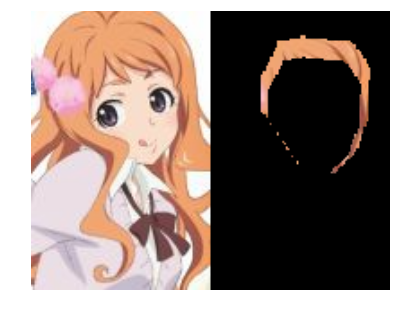

((-0.5, 199.5, 155.5, -0.5), None)

In [7]:
def hairPerimeter(img):
    # get center mass of filled convex hull
    resized = [cv2.resize(img['hull'], (0,0), fx=x, fy=x) for x in [1.1, 1.3]]
    COM = [np.mean(x.nonzero()[:2], axis=1) for x in [img['hull']] + resized]
    D_COM = np.array(COM[1:]) - COM[0]
    coords = [list(resized[x].nonzero()) for x in range(2)]
    
    # realign using the difference in the center of mass (D_COM) with
    # a bias for above the head
    for e in range(2):
        coords[e][0] = (coords[e][0] - 1.5*D_COM[e][0]).astype(np.uint32)
        coords[e][1] = (coords[e][1] - 1*D_COM[e][1]).astype(np.uint32)

    coords = [[x.astype(np.uint8) for x in coords[y]] for y in range(2)]
    H, L = img['orig'].shape[:2]

    # limit y range (avoid out of bound errors)
    for e in range(2):
        coords[e][0] = [min(x, H-1) for x in coords[e][0]]
        coords[e][1] = [max(x, 0) for x in coords[e][1]]

    # limit x range (avoid out of bound errors)
    for e in range(2):
        coords[e][1] = [min(x, L-1) for x in coords[e][1]]
        coords[e][1] = [max(x, 0) for x in coords[e][1]]

    # get outline
    M = np.zeros_like(img['hull'])
    
    # carve out region of interest from the two sets of scaled coordinates
    M[coords[1]] = 1
    M[coords[0]] = 0
    return M

img['hairPerimeter'] = hairPerimeter(img)
plt.imshow(cv2.cvtColor(
    np.hstack([img['orig'], img['hairPerimeter']*img['orig']]),
    cv2.COLOR_BGR2RGB
))
plt.axis('off'), plt.show()

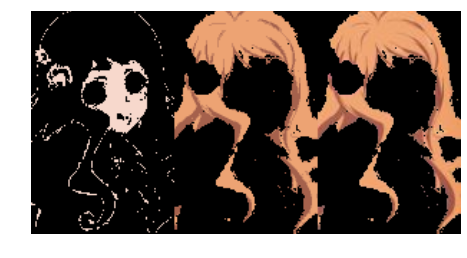

((-0.5, 299.5, 155.5, -0.5), None)

In [8]:
hairLine = (img['hairPerimeter']*img['reduced']).reshape(-1, 3)

# create structure [RGB, count] values
cols = np.array(list(Counter(map(tuple, hairLine)).most_common()[1:]))

# take colours comprising more than 10% of portion
cols[:, 1] /= cols[:, 1].sum()
cols = cols[cols[:, 1] > 0.04][:, 0]

# cast back into list of numpy arrays
cols = list(map(np.array, cols))

# get the predicted reduced output versus original output
stacked = np.sum(splitImage(img['reduced'], cols))
mask = np.zeros_like(stacked)
mask[stacked.nonzero()] = 1

# store variables
img['hairRedu_1'] = stacked
img['hairOrig_1'] = mask*img['orig']

# display first prediction
rcParams['figure.figsize'] = 20, 4
stacked = np.hstack([img['skin'], img['hairRedu_1'], img['hairOrig_1']])
plt.imshow(cv2.cvtColor(stacked, cv2.COLOR_BGR2RGB))
plt.axis('off'), plt.show()

# perhaps run a shilouetter coefficient here to filter out pointless colours?

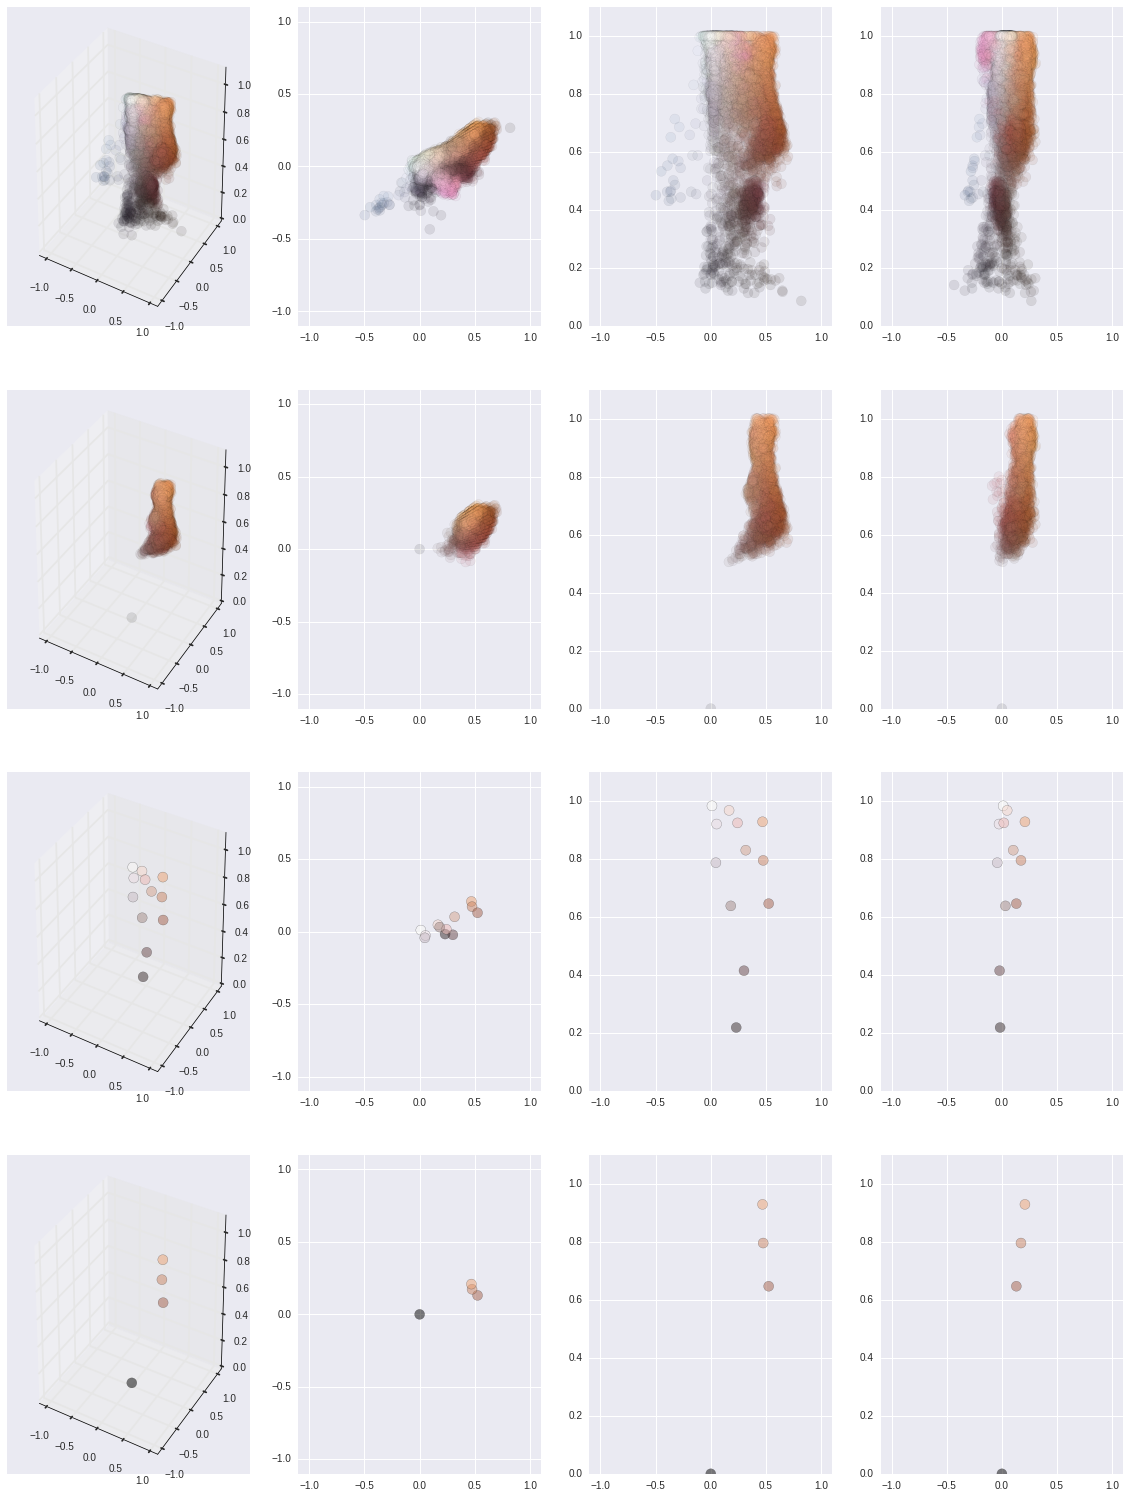

In [9]:
def RGB2HSV(img, visualize):
    """Convert coefficients and project into basis."""
    X = np.uint8(np.hstack([
        cv2.cvtColor(img, cv2.COLOR_BGR2HSV).reshape(-1, 3),
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB).reshape(-1, 3)
    ]))

    if (visualize):
        X = shuffle(np.vstack({tuple(r) for r in X})/255, random_state=0)
    else:
        X = np.vstack([tuple(r) for r in X])/255

    H, S, V, C = np.hsplit(X, [1, 2, 3])

    H *= 255/180*2*np.pi    
    P, Q = S*np.cos(H), S*np.sin(H)
    return np.hstack([P, Q, V, C])

def plotColorDist(img, pos, s, a):
    # transform the data into HSV space
    X = RGB2HSV(img, True)
    P, Q, V, C = np.hsplit(X, [1, 2, 3])

    # create 3d plot
    ax = fig.add_subplot(6, 4, pos, projection='3d')
    ax.scatter(P, Q, V, alpha=a, s=s, c=C)
    ax.set_xlim(-1.1, 1.1), ax.set_ylim(-1.1, 1.1), ax.set_zlim(0, 1.1)

    # plot 2d projections
    for e, x in enumerate(itertools.combinations([P, Q, V], 2)):
        ax = fig.add_subplot(6, 4, pos + 1 + e)
        ax.set_ylim(-1.1 if e==0 else 0, 1.1)
        ax.set_xlim(-1.1, 1.1)
        ax.scatter(x[0], x[1], alpha=a, s=s, c=C)

# get an idea of reduced colour distribution
rcParams['figure.figsize'] = 20, 40
fig = plt.figure()
plotColorDist(img['orig'], 1, 100, 0.1)
plotColorDist(img['hairOrig_1'], 5, 100, 0.1)
plotColorDist(img['reduced'], 9, 100, 0.5)
plotColorDist(img['hairRedu_1'], 13, 100, 0.5)